In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import scipy.optimize as opt

In [2]:
import ModelFunctions as mf

# Inputs

In [3]:
'''
input from bubble column 

Packed column dia.= 4.25 in. (0.10795 m), ht.= 1 m (before bubbling)
Gas flow rate = 22 LPM
(NO+NO2) % = 2.4 %
Total press. = 101.33 kN/m2
10 wt % HNO3
'''

Tc = 25 # [C]
pT = 101.33   # [kPa]
yO2 = 0.25
yN_star = 0.039
yNO_star = 0.1*yN_star
yH2O_star = 0.0

T = 273.15 + Tc    # [K]
yN_star_0 = yN_star

In [4]:
w = 10.0    # [%]

dia = 0.10795                               # [m]
ht_init = 1.0                               # [m]
A = np.pi*dia**2/4
vG = 22/1000/60/A                           # [m/s]

# Parameters calculation

In [5]:
rho_L = mf.density_HNO3(np.array([w]),np.array([Tc]))[0]*1000     # [kg/m^3]

S = np.pi*dia**2/4     # [m^2]
GT = vG*S*pT/8.314/T   # [kmol/s]

print('total gas flow rate = ', GT, ' kmol/s')

total gas flow rate =  1.4988723192157643e-05  kmol/s


In [6]:
k1,K2,K3,K4,K5 = mf.eqConst(T)
K6 = mf.K6(T,w,K2)
print('k1 = %f kPa^-2 * s^-1\nK2 = %f kPa^-1\nK3 = %f kPa^-1\nK4 = %f kPa^-1\nK5 = %f kPa^-1\nK6 = %f kPa^-0.5' %(k1,K2,K3,K4,K5,K6))

k1 = 0.002755 kPa^-2 * s^-1
K2 = 0.064058 kPa^-1
K3 = 0.005127 kPa^-1
K4 = 0.013841 kPa^-1
K5 = 0.000091 kPa^-1
K6 = 26.002771 kPa^-0.5


In [7]:
rho_L = mf.density_HNO3(np.array([w]),np.array([Tc]))[0]*1000     # [kg/m^3]
rho_G0 = 1.29 # [kg/m^3] @ 0C
rho_G = rho_G0*(pT/101.33)*(273/T)          # [kg/m^3]
mu_G = 1.716e-5*(T/273)**1.5*(384/(T+111))  # [Pa * s]
D_L = 2.5e-9                                # [m^2/s]
mu_L = mf.mu_HNO3(w,Tc)*1e-3                # [Pa * s]
mu_w = np.exp(-3.7188 + 578.919/(T-137.546))*1e-3  # [Pa * s]

print('gas dendity is ', rho_G, ' kg/m^3')
print('gas viscosity is ', mu_G, ' Pa * s')
print('liquid dendity is ', rho_L, ' kg/m^3')
print('liquid viscosity is ', mu_L, ' Pa * s')
print('liquid diffusivity is ', D_L, ' m^2/s')
print('water viscosity is ', mu_w, ' Pa * s')

gas dendity is  1.1811839678014422  kg/m^3
gas viscosity is  1.838121446779539e-05  Pa * s
liquid dendity is  1052.3  kg/m^3
liquid viscosity is  0.0011237284717379766  Pa * s
liquid diffusivity is  2.5e-09  m^2/s
water viscosity is  0.0008921118589653651  Pa * s


In [8]:
D_G = mf.DGas([T, pT])
print('D_NO = ', D_G[0], ' m^2/s' )
print('D_NO2 = ', D_G[1], ' m^2/s' )
print('D_N2O3 = ', D_G[2], ' m^2/s' )
print('D_N2O4 = ', D_G[3], ' m^2/s' )
print('D_HNO2 = ', D_G[4], ' m^2/s' )
print('D_HNO3 = ', D_G[5], ' m^2/s' )
print('D_H2O = ', D_G[6], ' m^2/s' )

D_NO =  2.3293152263549173e-05  m^2/s
D_NO2 =  1.4178440508247321e-05  m^2/s
D_N2O3 =  9.450641968289852e-06  m^2/s
D_N2O4 =  9.800665744893178e-06  m^2/s
D_HNO2 =  1.3165694757658227e-05  m^2/s
D_HNO3 =  1.1140203256480039e-05  m^2/s
D_H2O =  2.5670949680595004e-05  m^2/s


In [9]:
HkD_NO2, HkD_N2O4, HkD_N2O3, H_HNO2 = mf.HkD([T, pT, w, rho_L])
print('HkD_NO2 = ', HkD_NO2, ' (kmol/s)/(m^2*(kN/m^2)^1.5)')
print('HkD_N2O4 = ', HkD_N2O4, ' (kmol/s)/(m^2*(kN/m^2))')
print('HkD_N2O3 = ', HkD_N2O3, ' (kmol/s)/(m^2*(kN/m^2))')
print('H_HNO2 = ', H_HNO2, ' (kmol/m^3)/(kN/m^2)')

HkD_NO2 =  1.4775201840808335e-07  (kmol/s)/(m^2*(kN/m^2)^1.5)
HkD_N2O4 =  5.493688684446007e-06  (kmol/s)/(m^2*(kN/m^2))
HkD_N2O3 =  1.0544121313667764e-05  (kmol/s)/(m^2*(kN/m^2))
H_HNO2 =  0.2145861135598137  (kmol/m^3)/(kN/m^2)


In [10]:
pH2O_i, pHNO3_i = mf.psatMix((100-w)/100/18/(w/100/63+(100-w)/100/18), w/100/63/(w/100/63+(100-w)/100/18), T)
pH2O_i = pH2O_i/1000
pHNO3_i = pHNO3_i/1000
print('pH2O_i = ', pH2O_i, ' kPa')
print('pHNO3_i = ', pHNO3_i, ' kPa')

pH2O_i =  3.02176830569958  kPa
pHNO3_i =  0.0001248270559068775  kPa


In [11]:
R = 8.314
g = 9.81
sigma_L = 0.0635  # [N/m]
epsilon_G = 0.053*(vG*100)**1.1
d_vs = dia*26*(g*dia**2*rho_L/sigma_L)**(-0.5)*(g*dia**3/(mu_L/rho_L)**2)**(-0.12)*(vG/np.sqrt(g*dia))**(-0.12)
area = 6*epsilon_G/d_vs

print('epsilon_G = ', epsilon_G*100, ' %')
print('volume surface mean bubble diameter = ', d_vs, ' m')
print('specific interface area = ', area, ' m^2/m^3')

epsilon_G =  24.394153422590247  %
volume surface mean bubble diameter =  0.005949848013875914  m
specific interface area =  245.99774682344344  m^2/m^3


In [12]:
# kL is calculated as eq 13 in "Measurement and modeling of nitrogen oxides absorption in a pressurized reactor relevant to CO2 compression and purification process"
kL = D_L/d_vs*0.0142*(mu_L/rho_L/D_L)**0.5*(g*d_vs**3/(mu_L/rho_L)**2)**0.25*(g*d_vs**2*rho_L/sigma_L)*(3/8)

# kGa is calculated as eq 9 in "Measurement and modeling of nitrogen oxides absorption in a pressurized reactor relevant to CO2 compression and purification process"

ratio_NO = 0.01
ratio = 1.5
kGa_NO2 = 2e3*D_G[1]**0.5*vG**0.88/(R*T) * ratio
kGa_N2O4 = 2e3*D_G[3]**0.5*vG**0.88/(R*T) * ratio
kGa_N2O3 = 2e3*D_G[2]**0.5*vG**0.88/(R*T) * ratio
kGa_HNO2 = 2e3*D_G[4]**0.5*vG**0.88/(R*T) * ratio
kGa_HNO3 = 2e3*D_G[5]**0.5*vG**0.88/(R*T) * ratio
kGa_H2O = 2e3*D_G[6]**0.5*vG**0.88/(R*T) * ratio
kGa_NO = 2e3*D_G[0]**0.5*vG**0.88/(R*T) * ratio_NO

print('kLa = ', kL*area, ' 1/s')
print('kGa_NO = ', kGa_NO, ' (kmol/s)/(m^3*(kN/m^2))')

epsilon_L = 1 - epsilon_G
ht = ht_init/epsilon_L

print('epsilon_G = ', epsilon_G*100, ' %')
print('Height = ', ht, ' m')

kLa =  0.0024019177196366753  1/s
kGa_NO =  2.295129523974682e-06  (kmol/s)/(m^3*(kN/m^2))
epsilon_G =  24.394153422590247  %
Height =  1.3226490347887854  m


# Initial gas phase and interface compositions

In [13]:
K = (K2, K3, K4, K5, pT)
vars = [T, pT, yO2, yN_star, yNO_star, yH2O_star, K]
yT, yNO, yNO2, yH2O, yN2O4, yN2O3, yHNO2, yHNO3 = mf.gas(vars)

# Report

print('yN2   = %f     xN2   = %5.2f %%\nyO2   = %f     xO2   = %5.2f %%\n'\
      'yH2O  = %f     xH2O  = %5.2f %%\nyNO   = %f     xNO   = %5.2f %%\n'\
      'yNO2  = %f     xNO2  = %5.2f %%\n'\
      'yN2O3 = %f     xN2O3 = %5.2f %%\nyN2O4 = %f     xN2O4 = %5.2f %%\n'\
      'yHNO2 = %f     xHNO2 = %5.2f %%\nyHNO3 = %f     xHNO3 = %5.2f %%' \
       %(1, 1/yT*100, yO2, yO2/yT*100, yH2O, yH2O/yT*100, yNO, yNO/yT*100, \
         yNO2, yNO2/yT*100, yN2O3, yN2O3/yT*100, yN2O4, yN2O4/yT*100, \
         yHNO2, yHNO2/yT*100, yHNO3, yHNO3/yT*100))
print('----------------     ----------------')
print('yT    = %f     xT    = %.2f %%' %(yT, 100))

yN2   = 1.000000     xN2   = 77.81 %
yO2   = 0.250000     xO2   = 19.45 %
yH2O  = 0.000000     xH2O  =  0.00 %
yNO   = 0.003857     xNO   =  0.30 %
yNO2  = 0.027447     xNO2  =  2.14 %
yN2O3 = 0.000043     xN2O3 =  0.00 %
yN2O4 = 0.003805     xN2O4 =  0.30 %
yHNO2 = 0.000000     xHNO2 =  0.00 %
yHNO3 = 0.000000     xHNO3 =  0.00 %
----------------     ----------------
yT    = 1.285152     xT    = 100.00 %


In [14]:
x_NOx_0 = (yNO+yNO2)/yT

In [15]:
pO2_o = pT*yO2/yT
pNO_o = pT*yNO/yT
pNO2_o = pT*yNO2/yT
pN2O4_o = pT*yN2O4/yT
pN2O3_o = pT*yN2O3/yT
pHNO2_o = pT*yHNO2/yT
pH2O_o = pT*yH2O/yT
pHNO3_o = pT*yHNO3/yT

K = (K2, K3, K4, K6, area, HkD_NO2, HkD_N2O4, HkD_N2O3, H_HNO2, pH2O_i, pNO_o, pNO2_o, pN2O4_o, pN2O3_o, pHNO2_o, kGa_NO2, kGa_N2O4, kGa_N2O3, kGa_HNO2, kGa_NO, kL)
vars = [T, pT, yO2, yN_star, yNO_star, yH2O_star, K]

pNO_i, pNO2_i, pN2O4_i, pN2O3_i, pHNO2_i, pN2O4_b, pNO2_b, pN2O3_b, pHNO2_b = mf.interface(vars)

In [16]:
print('pNO_o   = %f10.6 kPa     pNO_i    = %f10.6 kPa' %(pNO_o, pNO_i))
print('pNO2_o  = %f10.6 kPa     pNO2_i   = %f10.6 kPa     pNO2_b   = %f10.6 kPa' %(pNO2_o, pNO2_i, pNO2_b))
print('pN2O4_o = %f10.6 kPa     pN2O4_i  = %f10.6 kPa     pN2O4_b  = %f10.6 kPa' %(pN2O4_o, pN2O4_i, pN2O4_b))
print('pN2O3_o = %f10.6 kPa     pN2O3_i  = %f10.6 kPa     pN2O3_b  = %f10.6 kPa' %(pN2O3_o, pN2O3_i, pN2O3_b))
print('pHNO2_o = %f10.6 kPa     pHNO2_i  = %f10.6 kPa     pHNO2_b  = %f10.6 kPa' %(pHNO2_o, pHNO2_i, pHNO2_b))
print('pH2O_o  = %f10.6 kPa     pH2O_i   = %f10.6 kPa' %(pH2O_o, pH2O_i))
print('pHNO3_o = %f10.6 kPa     pHNO3_i  = %f10.6 kPa' %(pHNO3_o, pHNO3_i))

pNO_o   = 0.30412810.6 kPa     pNO_i    = 1.36670910.6 kPa
pNO2_o  = 2.16412510.6 kPa     pNO2_i   = 1.69952910.6 kPa     pNO2_b   = 1.48001610.6 kPa
pN2O4_o = 0.30001010.6 kPa     pN2O4_i  = 0.18502410.6 kPa     pN2O4_b  = 0.14031510.6 kPa
pN2O3_o = 0.00337410.6 kPa     pN2O3_i  = 0.01190810.6 kPa     pN2O3_b  = 0.01037010.6 kPa
pHNO2_o = 0.00000010.6 kPa     pHNO2_i  = 0.31168210.6 kPa     pHNO2_b  = 0.29085810.6 kPa
pH2O_o  = 0.00000010.6 kPa     pH2O_i   = 3.02176810.6 kPa
pHNO3_o = 0.00000010.6 kPa     pHNO3_i  = 0.00012510.6 kPa


In [17]:
G = GT/yT
xHNO3 = 18*(w/100)/(63*(1-w/100))

Ra_NO_G = kGa_NO*(pNO_i - pNO_o)
Ra_NO2_G = kGa_NO2*(pNO2_o - pNO2_i)
Ra_N2O4_G = kGa_N2O4*(pN2O4_o - pN2O4_i)
Ra_N2O3_G = kGa_N2O3*(pN2O3_o - pN2O3_i)
Ra_HNO3_G = kGa_HNO3*(pHNO3_o - pHNO3_i)
Ra_HNO2_G = kGa_HNO2*(pHNO2_o - pHNO2_i)
Ra_H2O_G = kGa_H2O*(pH2O_i - pH2O_o)

Ra_NO2_L = area*HkD_NO2*(pNO2_i - pNO2_b)**1.5
Ra_N2O4_L = area*HkD_N2O4*(pN2O4_i - pN2O4_b)
Ra_N2O3_L = area*HkD_N2O3*(pN2O3_i - pN2O3_b)
Ra_HNO2_L = kL*area*H_HNO2*(pHNO2_i - pHNO2_b)

# solve ODEs

In [18]:
dh = 0.001
heights = np.arange(0, ht+dh, dh)

In [19]:
def interface_check(vars):
    T, pT, yO2, yN_star, yNO_star, yH2O_star, para, pi = vars
    K2, K3, K4, K6, a, HkD_NO2, HkD_N2O4, HkD_N2O3, H_HNO2, pH2O_i, pNO_o, pNO2_o, pN2O4_o, pN2O3_o, pHNO2_o, kGa_NO2, kGa_N2O4, kGa_N2O3, kGa_HNO2, kGa_NO, kL = para
    pNO_i, pNO2_i = pi
    
    A1 = a*HkD_NO2/3
    A2 = 1/(K2**0.5*K6**(1/3))
    A3 = 2/3*K2*a*HkD_N2O4
    A4 = 1/(K2*K6**(2/3))
    A5 = 1/3*K3*a*HkD_N2O3
    A7 = 1/6*K4**0.5*pH2O_i**0.5*kL*a*H_HNO2
    A8 = 1/(K2**(1/4)*K6**(1/6))
    A9 = -1*K3*kGa_N2O3
    A10 = -0.5*K4**0.5*pH2O_i**0.5*kGa_HNO2
    A11 = -1*kGa_NO
    A12 = kGa_NO*pNO_o + kGa_N2O3*pN2O3_o + 0.5*kGa_HNO2*pHNO2_o
    
    B1 = 3*A1
    B2 = A2
    B3 = kGa_NO2
    B4 = 3*A3
    B5 = A4
    B6 = 2*K2*kGa_N2O4
    B7 = 3*A5
    B8 = -1*A9
    B9 = 3*A7
    B10 = -1*A10
    B11 = -1*kGa_NO2*pNO2_o - kGa_N2O3*pN2O3_o - 2*kGa_N2O4*pN2O4_o - 0.5*kGa_HNO2*pHNO2_o
    B12 = A8
    
    K = (A1,A2,A3,A4,A5,A7,A8,A9,A10,A11,A12,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12)
    

    if pNO2_i - A2*pNO_i**(1/3) >= 0:    
        eq1 = A1*(pNO2_i - A2*pNO_i**(1/3))**1.5 + A3*(pNO2_i**2 - A4*pNO_i**(2/3)) \
              + A5*(pNO_i*pNO2_i - A2*pNO_i**(4/3)) + A7*(pNO_i**0.5*pNO2_i**0.5 - A8*pNO_i**(2/3)) \
              + A9*pNO_i*pNO2_i + A10*pNO_i**0.5*pNO2_i**0.5 + A11*pNO_i + A12
        eq2 = B1*(pNO2_i - B2*pNO_i**(1/3))**1.5 + B3*pNO2_i + B4*(pNO2_i**2 - B5*pNO_i**(2/3)) \
              + B6*pNO2_i**2 + B7*(pNO_i*pNO2_i - B2*pNO_i**(4/3)) + B9*(pNO_i**0.5*pNO2_i**0.5 - B12*pNO_i**(2/3)) \
              + B8*pNO_i*pNO2_i + B10*pNO_i**0.5*pNO2_i**0.5 + B11
    else:
        eq1 = A9*pNO_i*pNO2_i + A10*pNO_i**0.5*pNO2_i**0.5 + A11*pNO_i + A12
        eq2 = B3*pNO2_i + B6*pNO2_i**2 + B8*pNO_i*pNO2_i + B10*pNO_i**0.5*pNO2_i**0.5 + B11

    return eq1,eq2

In [20]:
yN_star_total = []
yNOx = []
for height in heights:
    yNO_star = yNO_star - dh*S/G*(k1*pNO_o**2*pO2_o*epsilon_G/(8.314*T) - Ra_NO_G + Ra_N2O3_G + 0.5*Ra_HNO2_G - 0.5*Ra_HNO3_G)
    yN_star = yN_star - dh*S/G*(-1*Ra_NO_G + Ra_NO2_G + 2*Ra_N2O3_G + 2*Ra_N2O4_G + Ra_HNO2_G + Ra_HNO3_G)
    yH2O_star = yH2O_star - dh*S/G*(-1*Ra_H2O_G + 0.5*Ra_HNO2_G + 0.5*Ra_HNO3_G)
    yO2 = yO2 - dh*0.5*S/G*(k1*pNO_o**2*pO2_o*epsilon_G/(8.314*T))
    
    
    K_gas = (K2, K3, K4, K5, pT)
    vars_gas = [T, pT, yO2, yN_star, yNO_star, yH2O_star, K_gas]
    yT, yNO, yNO2, yH2O, yN2O4, yN2O3, yHNO2, yHNO3 = mf.gas(vars_gas)
    
    pO2_o = pT*yO2/yT
    pNO_o = pT*yNO/yT
    pNO2_o = pT*yNO2/yT
    pN2O4_o = pT*yN2O4/yT
    pN2O3_o = pT*yN2O3/yT
    pHNO2_o = pT*yHNO2/yT
    pH2O_o = pT*yH2O/yT
    pHNO3_o = pT*yHNO3/yT


    K_inter = (K2, K3, K4, K6, area, HkD_NO2, HkD_N2O4, HkD_N2O3, H_HNO2, pH2O_i, pNO_o, pNO2_o, pN2O4_o, pN2O3_o, pHNO2_o, kGa_NO2, kGa_N2O4, kGa_N2O3, kGa_HNO2, kGa_NO, kL)
    vars_inter = [T, pT, yO2, yN_star, yNO_star, yH2O_star, K_inter]

    pNO_i, pNO2_i, pN2O4_i, pN2O3_i, pHNO2_i, pN2O4_b, pNO2_b, pN2O3_b, pHNO2_b = mf.interface(vars_inter)
    
    vars_check = [T, pT, yO2, yN_star, yNO_star, yH2O_star, K_inter, (pNO_i, pNO2_i)]
    err_1, err_2 = interface_check(vars_check)
    if np.isnan(err_1) or np.isnan(err_2) or np.abs(err_1) > 1e-5 or np.abs(err_2) > 1e-5:
        print(height,yN_star, err_1, err_2)
    
    Ra_NO_G = max(kGa_NO*(pNO_i - pNO_o),0)
    Ra_NO2_G = max(kGa_NO2*(pNO2_o - pNO2_i),0)
    Ra_N2O4_G = max(kGa_N2O4*(pN2O4_o - pN2O4_i),0)
    Ra_N2O3_G = max(kGa_N2O3*(pN2O3_o - pN2O3_i),0)
    Ra_HNO3_G = max(kGa_HNO3*(pHNO3_o - pHNO3_i),0)
    Ra_HNO2_G = max(kGa_HNO2*(pHNO2_o - pHNO2_i),0)
    Ra_H2O_G = max(kGa_H2O*(pH2O_i - pH2O_o),0)
    
    yN_star_total.append(yN_star)
    yNOx.append((yNO+yNO2+2*yN2O3+2*yN2O4+yHNO2+yHNO3)/yT)

In [21]:
print('NOx removal efficiency is ', 100*(1 - yN_star/yN_star_0), ' %')

NOx removal efficiency is  52.013784153842124  %


In [22]:
print('pNO_o   = %f10.6 kPa     pNO_i    = %f10.6 kPa' %(pNO_o, pNO_i))
print('pNO2_o  = %f10.6 kPa     pNO2_i   = %f10.6 kPa     pNO2_b   = %f10.6 kPa' %(pNO2_o, pNO2_i, pNO2_b))
print('pN2O4_o = %f10.6 kPa     pN2O4_i  = %f10.6 kPa     pN2O4_b  = %f10.6 kPa' %(pN2O4_o, pN2O4_i, pN2O4_b))
print('pN2O3_o = %f10.6 kPa     pN2O3_i  = %f10.6 kPa     pN2O3_b  = %f10.6 kPa' %(pN2O3_o, pN2O3_i, pN2O3_b))
print('pHNO2_o = %f10.6 kPa     pHNO2_i  = %f10.6 kPa     pHNO2_b  = %f10.6 kPa' %(pHNO2_o, pHNO2_i, pHNO2_b))
print('pH2O_o  = %f10.6 kPa     pH2O_i   = %f10.6 kPa' %(pH2O_o, pH2O_i))
print('pHNO3_o = %f10.6 kPa     pHNO3_i  = %f10.6 kPa' %(pHNO3_o, pHNO3_i))

pNO_o   = 0.46832910.6 kPa     pNO_i    = 0.46772610.6 kPa
pNO2_o  = 0.76562910.6 kPa     pNO2_i   = 0.76562410.6 kPa     pNO2_b   = 1.03523410.6 kPa
pN2O4_o = 0.03755010.6 kPa     pN2O4_i  = 0.03754910.6 kPa     pN2O4_b  = 0.06865110.6 kPa
pN2O3_o = 0.00183810.6 kPa     pN2O3_i  = 0.00183610.6 kPa     pN2O3_b  = 0.00248210.6 kPa
pHNO2_o = 0.12236610.6 kPa     pHNO2_i  = 0.12238110.6 kPa     pHNO2_b  = 0.14230610.6 kPa
pH2O_o  = 3.01713410.6 kPa     pH2O_i   = 3.02176810.6 kPa
pHNO3_o = 0.01619710.6 kPa     pHNO3_i  = 0.00012510.6 kPa


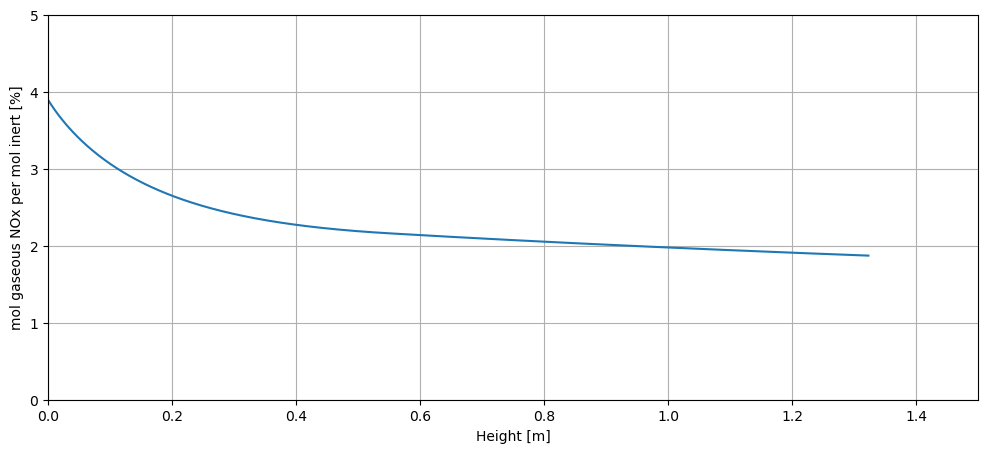

In [23]:
plt.figure(figsize=(12,5))
plt.plot(heights, np.array(yN_star_total)*100)
plt.xlabel('Height [m]')
plt.ylabel('mol gaseous NOx per mol inert [%]')
plt.axis([0,1.5, 0, 5])
plt.grid()

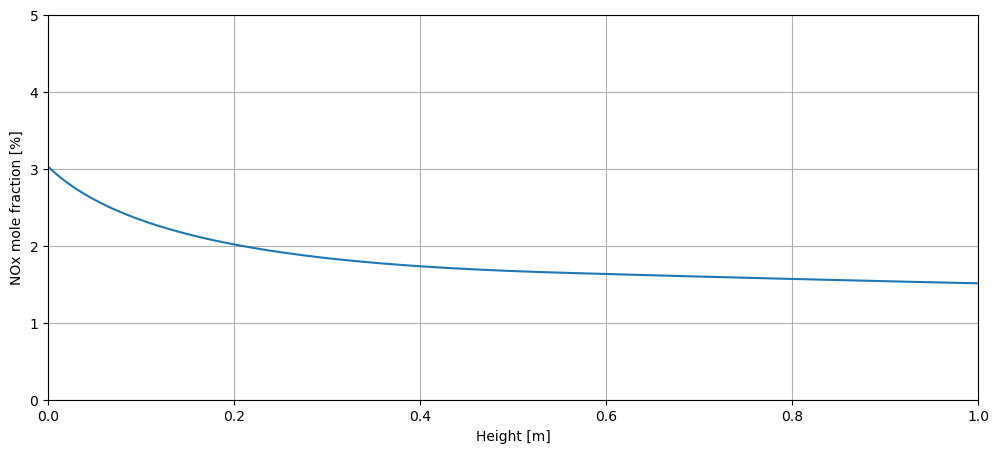

In [24]:
plt.figure(figsize=(12,5))
plt.plot(heights, np.array(yNOx)*100)
plt.xlabel('Height [m]')
plt.ylabel('NOx mole fraction [%]')
plt.axis([0,1.0, 0, 5])
plt.grid()

In [25]:
print('NOx measured at the inlet is ', x_NOx_0*100, ' %')
print('NOx measured at the outlet is ', (yNO+yNO2)/yT*100, ' %')
print('The NOx absorption efficiency by NOx measurement is ', (1-(yNO+yNO2)/yT/x_NOx_0)*100, ' %')

NOx measured at the inlet is  2.4358557818171076  %
NOx measured at the outlet is  1.2177613951445394  %
The NOx absorption efficiency by NOx measurement is  50.00683520614222  %
